In [49]:
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import Pool
import traceback
import os
import pickle

import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt
from pydantic import BaseSettings, BaseModel
from joblib import Parallel, delayed
import tensorflow as tf

from scrap_optimization import ScrapOptimization

In [14]:
class GeneralInfo(BaseModel):
    features:list
    target: str
    chemi_names: list
    train_dataset: str
    scrap_dataset: str
    chemi_dataset:str
    ML_MODELS:str
    violation_threshold:float

class SimulationInfo(BaseModel):
    id: int
    steel_type: str
    total_quantity:int
    epochs: int
    feature: int

class Settings(BaseSettings):
    general_info:GeneralInfo
    simulations: list[SimulationInfo]


settings = Settings.parse_file("settings.json")
simulations = settings.simulations
general_info = settings.general_info
supplier_quantity_hist = []
df_schrott = pd.read_csv(general_info.scrap_dataset)
df_schrott = df_schrott[df_schrott["name"].str.startswith("F")]

In [15]:
def run_simulation(simulation):
    simulation_settings,df_schrott,supplier_quantity_hist, sim_id_hist = simulation

    try:
        so = ScrapOptimization(general_info, simulation_settings)
        steel_chemi_df = pd.read_csv("assets/steel_chemi_components.csv")
        chemies = steel_chemi_df.loc[steel_chemi_df["name"] == float(simulation_settings.steel_type)]
        chemies = chemies[['C','Si','Mn','Cr','Mo','V']].values
        chemi_component = [float(i) for i in chemies[0]] 
        print(f"Running optimization for id:{simulation_settings.id}")
        so.optimize(simulation_settings.total_quantity, chemi_component, simulation_settings.steel_type, df_schrott, supplier_quantity_hist,sim_id_hist)
    except Exception as e:
        print("Error:")
        print(e)
        print(traceback.format_exc())

In [16]:
with multiprocessing.Manager() as manager:
    lock = manager.Lock()
    supplier_quantity_hist = manager.list()
    sim_id_hist = manager.list()
    ns = manager.Namespace()
    ns.df_schrott = df_schrott

    simulations = [(item, ns, supplier_quantity_hist, sim_id_hist) for item in simulations]
    supplier_quantity_hist.append(ns.df_schrott["quantity"].to_list())
    core_count = 8
    with Pool(core_count) as p:
        p.map(run_simulation, simulations)
    # run_simulation(simulations[0])
    print("len(supplier_quantity_hist): ",len(supplier_quantity_hist))

Running optimization for id:2Running optimization for id:5Running optimization for id:1Running optimization for id:4Running optimization for id:3Running optimization for id:6



Running optimization for id:7Running optimization for id:8

[0.0153 0.003  0.0035 0.12   0.008  0.008 ][0.0153 0.003  0.0035 0.12   0.008  0.008 ][0.0153 0.003  0.0035 0.12   0.008  0.008 ][0.0153 0.003  0.0035 0.12   0.008  0.008 ]





[0.0153 0.003  0.0035 0.12   0.008  0.008 ][0.0153 0.003  0.0035 0.12   0.008  0.008 ]

[0.0153 0.003  0.0035 0.12   0.008  0.008 ][0.0153 0.003  0.0035 0.12   0.008  0.008 ]



In [9]:
all_hist = np.empty(shape=(1,len(supplier_quantity_hist)))
fig, axes = plt.subplots(1,2, figsize=(15, 7))
for idx, remote_scrap in enumerate(supplier_quantity_hist[0]):
    values = []
    for i in range(len(supplier_quantity_hist)):
        values.append(supplier_quantity_hist[i][idx])
        all_hist = np.vstack((all_hist, np.array(values).reshape(1,-1)))
    if values.count(values[0]) != len(values):
        axes[0].plot(range(len(supplier_quantity_hist)), values, label=f"F{idx+1}",linewidth=0.5)
np.save("saved_plt.npy", all_hist)
# plt.title(f"ID: {self.sim_settings.id}, Total quantity: {self.sim_settings.total_quantity}")
# plt.legend()
# plt.savefig(f"sim_output/simulation_output_{self.sim_settings.id}.png")

# plt.show()

print(f"sim_id_hist= {[item for item in sim_id_hist]}")
counts = [0]*8
for item in sim_id_hist:
    counts[item-1] += 1

axes[1].bar(range(core_count), counts)
plt.savefig(f"sim_output/simulation_output2.png")
plt.show()

BrokenPipeError: [Errno 32] Broken pipe

(161, 41)


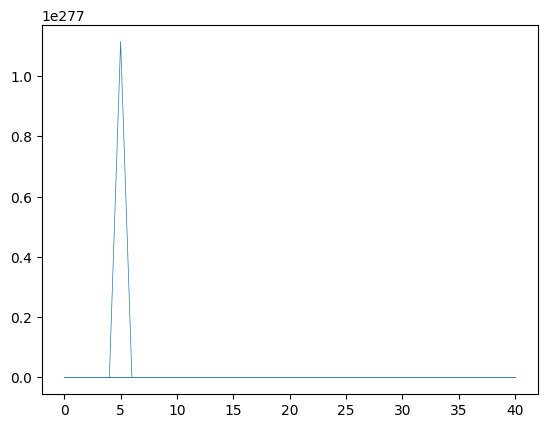

In [52]:
data = np.load("saved_plt.npy")
print(data.shape)
for idx, row in enumerate(data):
    plt.plot(range(row.shape[0]), row, linewidth=0.5)
plt.show()

In [53]:
data[0]

array([4.67327013e-310, 0.00000000e+000, 6.90115471e-310, 2.93300644e+222,
       1.43616552e+161, 1.11487599e+277, 1.53044312e-094, 1.92220806e+227,
       2.17237419e-153, 7.26581901e+223, 6.96742101e+252, 4.67353047e+257,
       6.46572285e+170, 3.94655055e+180, 1.50762161e+161, 2.43813655e-152,
       8.44691167e+252, 3.42134148e+180, 9.05280140e+223, 4.52342134e+257,
       9.27777192e+242, 2.13067786e-313, 6.90098518e-310, 6.90098524e-310,
       6.90098524e-310, 6.90098524e-310, 6.90098524e-310, 6.90098536e-310,
       6.90098530e-310, 6.90098536e-310, 6.90087174e-310, 6.90098265e-310,
       6.90098530e-310, 6.90098540e-310, 6.90098536e-310, 6.90098530e-310,
       6.90098536e-310, 6.90087174e-310, 6.90098537e-310, 6.90098530e-310,
       2.29246460e-321])

In [51]:
with open("saved_plt0", "rb") as fp:   # Unpickling
    values = pickle.load(fp)

values[0]

[6090,
 5933.290575598512,
 5776.581151197024,
 5619.871726795536,
 5463.162302394048,
 5306.45287799256,
 5149.7434535910725,
 4993.0340291895845,
 4836.324604788097,
 4770.526925450653,
 4704.729246113209,
 4638.9315667757655,
 4573.133887438322,
 4405.872644115067,
 4291.384978503959,
 4127.467154393103,
 4083.1903259556643,
 3971.722397805638,
 3860.254469655612,
 3640.3228172673525,
 3420.391164879093,
 3202.1404354981846,
 2994.0120789954076,
 2781.8314020163666,
 2708.0476342899146,
 2488.437259465431,
 2424.677476212612,
 2332.490887272323,
 2238.4835882848765,
 2144.47628929743,
 2032.1479804504447,
 1957.3489662775091,
 1814.3995182783917,
 1608.0862640119803,
 1549.4309263299783,
 1467.6141427352454,
 1385.9170979534017,
 1302.5448607142528,
 1212.4329059049107,
 1129.0042172913518,
 1058.5014415049432]

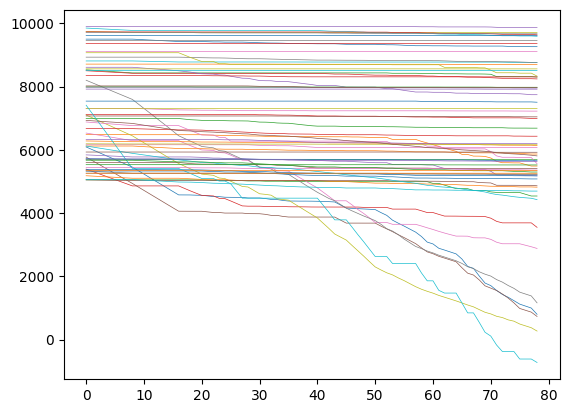

In [43]:


for idx, row in enumerate(data):
    # unique, counts = np.unique(row, return_counts=True)
    if not np.all(np.isclose(row, row[0])) and not np.all(row[:10]<1) and np.nan not in row  :
        plt.plot(range(row.shape[0]), row, linewidth=0.5)
        print
plt.show()